In [1]:
import os
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2



In [2]:
zip_file_paths = [
    '/content/aadhaar-20230906T052513Z-001.zip',
    '/content/driving_licence-20230906T052513Z-001.zip',
    '/content/others-20230906T052514Z-001.zip',
    '/content/pan-20230906T052515Z-001.zip',
    '/content/passport-20230906T052517Z-001.zip',
    '/content/voter_id-20230906T052518Z-001.zip'
]

In [3]:
data_dir =  'zip_file_paths'

os.makedirs(data_dir, exist_ok=True)

In [4]:
# Iterate through each zip file path
for zip_file_path in zip_file_paths:
# Extract the contents of the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

In [5]:
extracted_contents = os.listdir(data_dir)
print("Extracted contents:")
for item in extracted_contents:
    print(item.upper())

Extracted contents:
AADHAAR
VOTER_ID
PAN
DRIVING_LICENCE
PASSPORT
OTHERS


In [6]:
num_classes = 6
image_size = (224, 224)

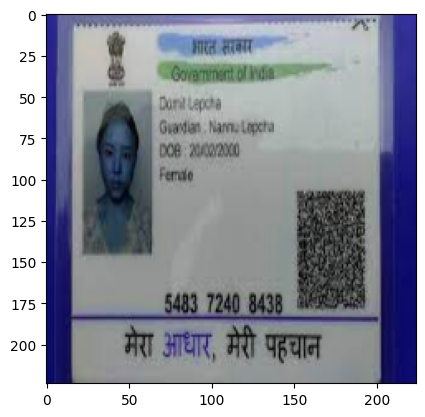

In [7]:
# Data Loading and Preprocessing
def load_and_preprocess_data(data_dir, image_size):
    images = []
    labels = []

    for class_label, class_name in enumerate(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, class_name)

        for image_filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_filename)
            image = cv2.imread(image_path)

            if image is not None:
                image = cv2.resize(image, image_size)

                images.append(image)
                labels.append(class_label)

    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_data(data_dir, image_size)
plt.imshow(images[0])


In [8]:
# Split the Data into Train, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=12)

In [9]:
# Convert Labels to One-Hot Encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
# Build a CNN Model &  Define the CNN model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 222, 222, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 128)     512       
 chNormalization)                                                
                                                        

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Train the Model (add data augmentation, early stopping, and model checkpointing)
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [13]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
# Model checkpointing
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [15]:
 #Learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return learning_rate
    elif epoch < 20:
        return learning_rate * 0.1
    else:
        return learning_rate * 0.01

In [16]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [17]:
# Adjust hyperparameters
batch_size = 32
learning_rate = 1e-4
epochs = 50
dropout_rate = 0.5


In [18]:
# Training with augmentation, early stopping, model checkpointing, and learning rate schedule
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, lr_scheduler])

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 15.4334 - accuracy: 0.4000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 27s 896ms/step - loss: 15.4334 - accuracy: 0.4000 - val_loss: 45.3638 - val_accuracy: 0.2381 - lr: 1.0000e-04
Epoch 2/50
14/14 [==============================] - 11s 817ms/step - loss: 14.8325 - accuracy: 0.4976 - val_loss: 29.4095 - val_accuracy: 0.2381 - lr: 1.0000e-04
Epoch 3/50
14/14 [==============================] - 13s 977ms/step - loss: 14.3678 - accuracy: 0.5452 - val_loss: 20.3494 - val_accuracy: 0.3492 - lr: 1.0000e-04
Epoch 4/50
14/14 [==============================] - 15s 1s/step - loss: 14.1057 - accuracy: 0.5976 - val_loss: 17.5382 - val_accuracy: 0.3492 - lr: 1.0000e-04
Epoch 5/50
14/14 [==============================] - 5s 360ms/step - loss: 14.0510 - accuracy: 0.5929 - val_loss: 17.5697 - val_accuracy: 0.3095 - lr: 1.0000e-04
Epoch 6/50
14/14 [==============================] - 13s 968ms/step - loss: 13.7916 - accuracy: 0.6333 - val_loss: 16.4072 - val_accuracy: 0.3413 - lr: 1.0000e-04
Epoch 7/50
14/14 [=========================

In [19]:
#Evaluate the Model
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 754ms/step


In [20]:
# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
mcc = matthews_corrcoef(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
auc = roc_auc_score(y_test, y_pred, average='macro')

In [21]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')
print(f'AUC: {auc}')

Accuracy: 0.7037037037037037
Precision: 0.7092592592592593
Recall: 0.7114962651727358
F1 Score: 0.6970291146761735
MCC: 0.6380310468810652
AUC: 0.9408035691356895


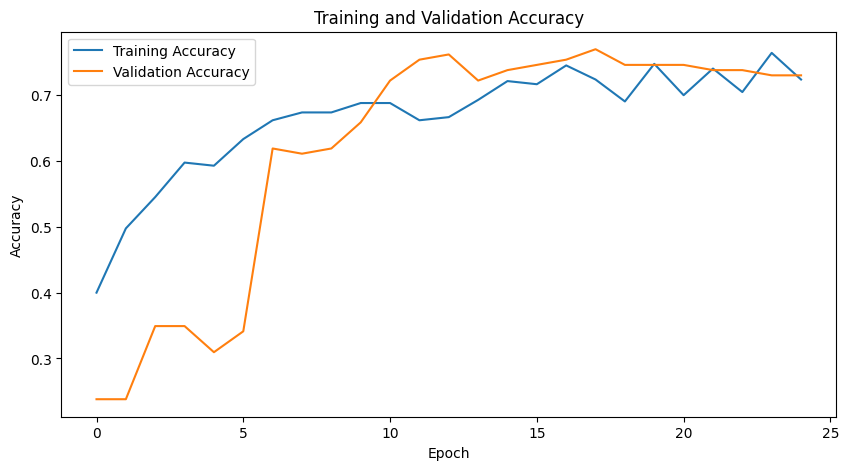

In [22]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

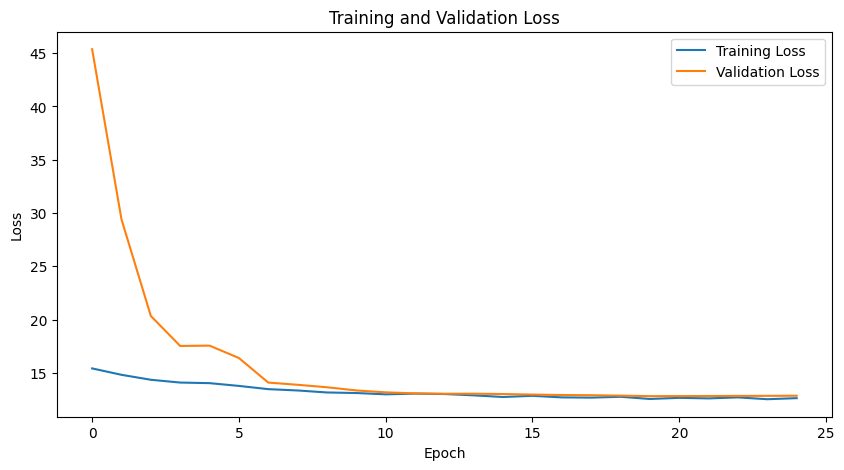

In [23]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)
cr=classification_report(y_true_classes, y_pred_classes)
print(cr.upper())

2/2 [==============================] - 0s 38ms/step
[[ 5  0  1  2  0  0]
 [ 0  4  0  0  0  2]
 [ 0  0  6  0  0  0]
 [ 1  1  2 12  0  1]
 [ 3  0  0  0  4  0]
 [ 0  0  1  1  1  7]]
              PRECISION    RECALL  F1-SCORE   SUPPORT

           0       0.56      0.62      0.59         8
           1       0.80      0.67      0.73         6
           2       0.60      1.00      0.75         6
           3       0.80      0.71      0.75        17
           4       0.80      0.57      0.67         7
           5       0.70      0.70      0.70        10

    ACCURACY                           0.70        54
   MACRO AVG       0.71      0.71      0.70        54
WEIGHTED AVG       0.72      0.70      0.70        54



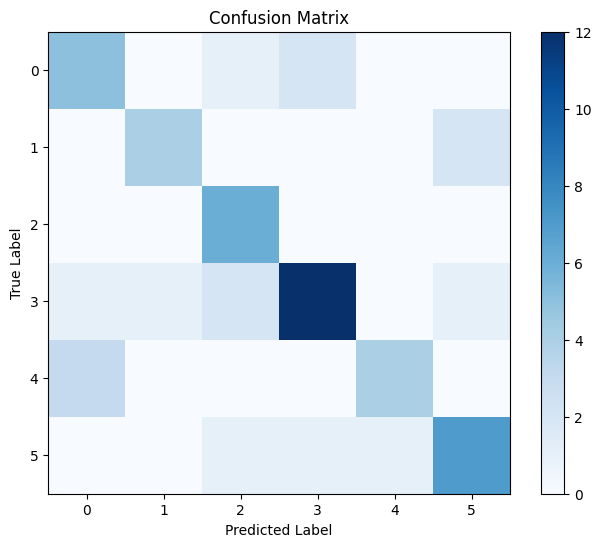

In [25]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')

plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

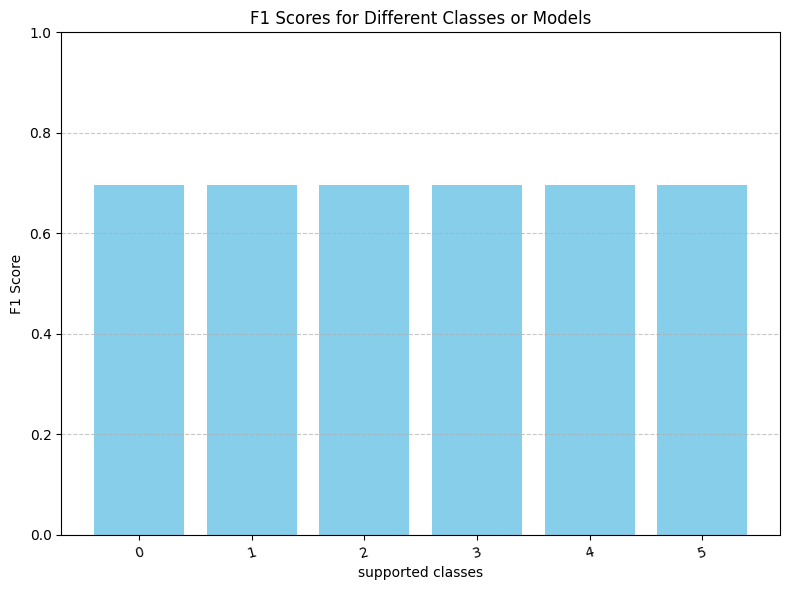

In [26]:
plt.figure(figsize=(8, 6))
plt.bar(labels, f1, color='skyblue')
plt.xlabel('supported classes')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Different Classes or Models')
plt.ylim(0, 1.0)  # Set the y-axis range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)  # Rotate the x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [ ]:
print(eval(input("Enter Expression: ")))

In [ ]:
""